In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Loading the data

In [2]:
import yfinance

raw_data = yfinance.download(tickers = "^GSPC ^FTSE ^N225 ^GDAXI",
                             start = "1994-01-07", end = "2018-01-29",
                             interval = "1d", group_by = 'ticker',
                             auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()

In [4]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [5]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

### Creating Returns

In [6]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

### Splitting the Data

In [7]:
benchmark = int(len(df_comp) * 0.8)
df = df_comp.iloc[:benchmark].copy()
df_test = df_comp.iloc[benchmark:].copy()

### Fitting a Model

In [8]:
from pmdarima.arima import auto_arima

# find the best ARIMA model using default arguments
model_auto = auto_arima(df.ret_ftse[1:])
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5019
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -7882.776
Date:                Sun, 20 Nov 2022   AIC                          15785.552
Time:                        18:28:37   BIC                          15850.762
Sample:                    01-11-1994   HQIC                         15808.403
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0112      0.082      0.137      0.891      -0.149       0.171
ar.L2         -0.6541      0.077     -8.452      0.000      -0.806      -0.502
ar.L3         -0.1635      0.071     -2.299      0.022      -0.303      -0.024
ar.L4          0.2016      0.074      2.713      0.007       0.056       0.347
ma.L1         -0.0348      0.081     -0.429      0.668      -0.194       0.124
ma.L2          0.6066      0.078      7.766      0.000       0.454       0.760
ma.L3          0.0629      0.068      0.918      0.358      -0.071       0.197
ma.L4         -0.1936      0.073     -2.651      0.008      -0.337      -0.050
ma.L5         -0.1052      0.010    -11.065      0.000      -0.124      -0.087
sigma2         1.3544      0.015     91.429      0.000       1.325       1.383
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6354.97
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
model_auto

ARIMA(order=(4, 0, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Turns out that the best model is ARMA(4, 5)!

### Important Arguments

In [10]:
model_auto = auto_arima(y = df.ret_ftse[1:], 
                        X = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], # outside factors (e.g other time series)
                        m = 5, # The period for seasonal differencing
                        max_order = None, # maximum amount of variables to be used in the regression (p + q)
                        max_p = 7, # maximum AR components
                        max_q = 7, # maximum MA components
                        max_d = 2, # maximum Integrations
                        max_P = 5, # seasonal model param P
                        max_Q = 5, # seasonal model param Q
                        max_D = 2, # seasonal model param D
                        maxiter = 50, # maximum iterations we're giving the model to converge the coefficients
                        alpha = 0.05, # level of significance
                        trend = 'ct', 
                        information_criterion = 'oob', # criteria we use to compare different models ('aic', 'aicc', 'bic', 'hqic', 'oob')
                        out_of_sample_size = int(len(df_comp) * 0.2)) # validates the model selection

In [11]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5019
Model:                        SARIMAX   Log Likelihood               -5403.757
Date:                Sun, 20 Nov 2022   AIC                          10819.514
Time:                        18:30:48   BIC                          10858.640
Sample:                             0   HQIC                         10833.225
                               - 5019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.021      0.037      0.970      -0.041       0.042
drift      -2.268e-06   7.51e-06     -0.302      0.763    -1.7e-05    1.24e-05
x1             0.0644      0.006     11.165      0.000       0.053       0.076
x2             0.5198      0.005    103.247      0.000       0.510       0.530
x3             0.0662      0.004     14.885      0.000       0.057       0.075
sigma2         0.4784      0.004    110.493      0.000       0.470       0.487
===================================================================================
Ljung-Box (L1) (Q):                  61.39   Jarque-Bera (JB):             15472.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Simple prediction

In [12]:
df_test['ftse_pred'] = model_auto.predict(n_periods = len(df_test), 
                                         X = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']])

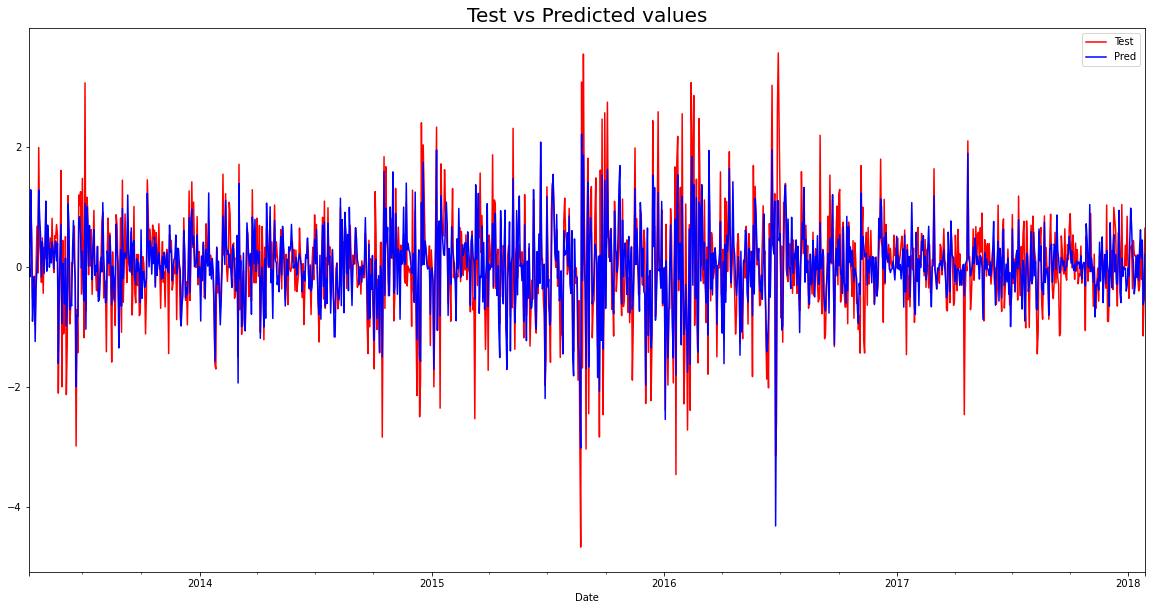

In [13]:
plt.figure(figsize = (20, 10))
df_test.ret_ftse.plot(label = 'Test', color = 'red')
df_test.ftse_pred.plot(label = 'Pred', color = 'blue')
plt.title("Test vs Predicted values", size = 20)
plt.legend()
plt.show()

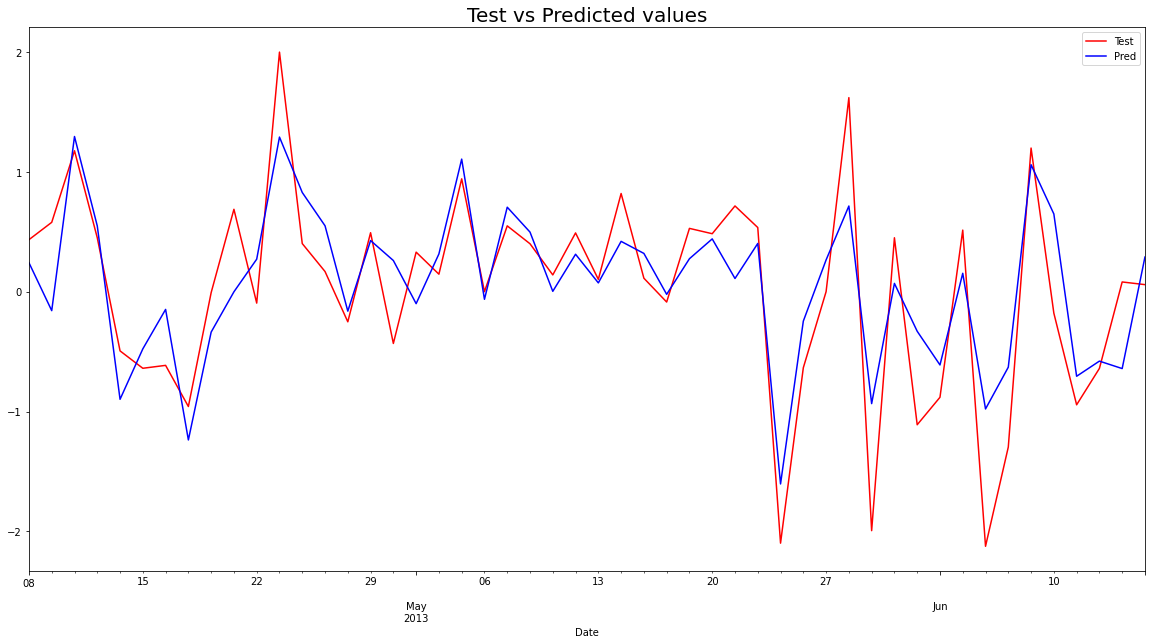

In [14]:
# look on the plot a bit closer
plt.figure(figsize = (20, 10))
df_test.iloc[:50].ret_ftse.plot(label = 'Test', color = 'red')
df_test.iloc[:50].ftse_pred.plot(label = 'Pred', color = 'blue')
plt.title("Test vs Predicted values", size = 20)
plt.legend()
plt.show()

Great!